Processing reference image 1/56: frame_0000.jpg
Processing reference image 2/56: frame_0001.jpg
Processing reference image 3/56: frame_0002.jpg
Processing reference image 4/56: frame_0003.jpg
Processing reference image 5/56: frame_0004.jpg
Processing reference image 6/56: frame_0005.jpg
Processing reference image 7/56: frame_0006.jpg
Processing reference image 8/56: frame_0007.jpg
Processing reference image 9/56: frame_0008.jpg
Processing reference image 10/56: frame_0009.jpg
Processing reference image 11/56: frame_0010.jpg
Processing reference image 12/56: frame_0011.jpg
Processing reference image 13/56: frame_0012.jpg
Processing reference image 14/56: frame_0013.jpg
Processing reference image 15/56: frame_0014.jpg
Processing reference image 16/56: frame_0015.jpg
Processing reference image 17/56: frame_0016.jpg
Processing reference image 18/56: frame_0017.jpg
Processing reference image 19/56: frame_0018.jpg
Processing reference image 20/56: frame_0019.jpg
Processing reference image 21

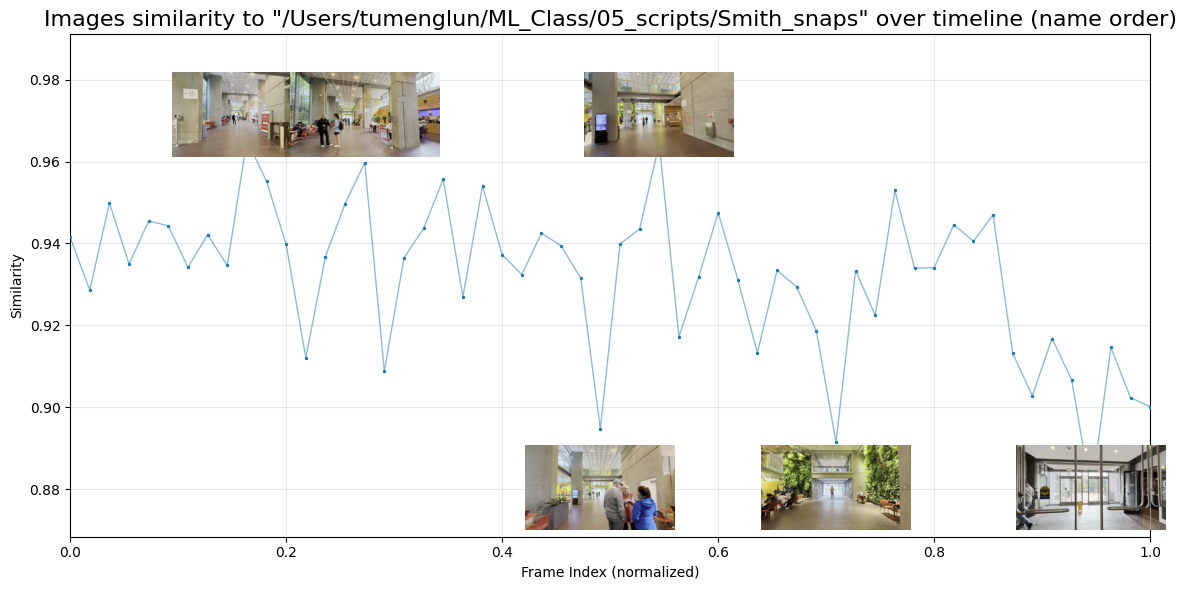

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from CLIP_helper import *  # uses your encode_image()
import os, re
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# -------- order helpers ----------
ORDER_MODE = "name"  # "name" (natural filename) or "ctime" (creation time)

IMG_EXTS = ('.png', '.jpg', '.jpeg')

def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.findall(r'\d+|\D+', s)]

def sorted_images(folder):
    files = [f for f in os.listdir(folder) if f.lower().endswith(IMG_EXTS)]
    if ORDER_MODE == "ctime":
        # On macOS, st_birthtime exists; on others, fallback to mtime
        def key_fn(f):
            p = os.path.join(folder, f)
            st = os.stat(p)
            return getattr(st, "st_birthtime", st.st_mtime)
        files.sort(key=key_fn)
    else:
        files.sort(key=natural_key)
    return files

# -----------------------------
# 1) Build reference vector
# -----------------------------
ref_folder = "/Users/tumenglun/ML_Class/05_scripts/Smith_snaps"
ref_image_files = sorted_images(ref_folder)

# 512-D accumulator
ref_vec = np.zeros((512,), dtype=np.float32)

# Sum unit image vectors from the reference folder (in enforced order)
for i, img in enumerate(ref_image_files):
    print(f'Processing reference image {i+1}/{len(ref_image_files)}: {img}')
    img_path = os.path.join(ref_folder, img)
    img_vec = encode_image(img_path).astype(np.float32)  # your helper returns normalized (512,)
    ref_vec += img_vec

# Normalize the reference vector
ref_norm = np.linalg.norm(ref_vec)
ref_vec = ref_vec / (ref_norm if ref_norm != 0 else 1.0)

# -----------------------------
# 2) Compute similarities IN SEQUENCE (NO SORT)
# -----------------------------
folder = "/Users/tumenglun/ML_Class/05_scripts/Smith_snaps"
image_files = sorted_images(folder)   # enforce same ordering here

similarities = []
for img in image_files:
    img_path = os.path.join(folder, img)
    img_vec = encode_image(img_path).astype(np.float32)
    similarity = float(np.dot(ref_vec, img_vec))
    similarities.append((similarity, img_path))
    print(f'"{ref_folder}" __in__ {img}: {similarity:.4f}')

# -----------------------------
# Timeline plot: scatter + line + thumbnails
# -----------------------------
frames_num = len(similarities)
if frames_num == 0:
    raise ValueError("No valid images found for plotting.")

xs = [i / (frames_num - 1.0) if frames_num > 1 else 0.0 for i in range(frames_num)]
ys = [sim for sim, _ in similarities]

q10 = float(np.quantile(ys, 0.05))
q90 = float(np.quantile(ys, 0.95))

ymin, ymax = float(min(ys)), float(max(ys))
yr = (ymax - ymin) if ymax > ymin else 1.0
pad = 0.12 * yr
top_extra = 2.5 * pad
bot_extra = 1.0 * pad

thumb_y_bottom = ymin - 0.85 * pad
thumb_y_top    = ymax + pad + 0.6 * pad

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0.0, 1.0)
ax.set_ylim(ymin - bot_extra, ymax + top_extra)

ax.scatter(xs, ys, s=2.0, zorder=3)
ax.plot(xs, ys, linewidth=1, alpha=0.5, zorder=2)

thumb_zoom_bottom = 0.1
thumb_zoom_top    = 0.1

for i, (sim, img) in enumerate(similarities):
    if sim <= q10 or sim >= q90:
        im_bgr = cv2.imread(img)
        if im_bgr is None:
            continue
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        oi = OffsetImage(im_rgb, zoom=(thumb_zoom_top if sim >= q90 else thumb_zoom_bottom), resample=True)

        if sim <= q10:
            ab = AnnotationBbox(oi, (xs[i], thumb_y_bottom), frameon=False,
                                box_alignment=(0.5, 0.0), clip_on=False)
        else:
            ab = AnnotationBbox(oi, (xs[i], thumb_y_top), frameon=False,
                                box_alignment=(0.5, 1.0), clip_on=False)
        ax.add_artist(ab)

ax.set_title(f'Images similarity to "{ref_folder}" over timeline ({ORDER_MODE} order)', fontsize=16)
ax.set_xlabel('Frame Index (normalized)')
ax.set_ylabel('Similarity')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
